## Visualizing and converting pinnacle data

The purpose of this code is for visualizing data, running analyses, and other general scripting things.

There will be a subfolder "projects" where various notebooks and scripts/functions will be stored.

More general functions will be placed in the src folder to be used for analysis

---

Requirements:
1. Anaconda3
2. VScode or Spyder (code written in VScode, would recommend)

---

#### First Installation:

These lines are for if you want to save data using NWB

        conda create -n decode_lab_env python=3.9
        conda activate decode_lab_env
        git clone https://github.com/JohnStout/hernan-lab-to-nwb 
        cd hernan-lab-to-nwb
        pip install -e .

These lines are for this toolbox

        git clone https://github.com/JohnStout/decode_lab_code
        cd decode_lab_code
        pip install -e .

---
## For repeated use:
Open your VScode or IDE of choice, and select your kernel

        decode_lab_env

---

### Some potential toolboxes
https://github.com/preraulab/multitaper_toolbox/tree/master

<img src="/Users/js0403/hernan-lab-to-nwb/tests/idealized workflow.png" />

# Pinnacle

Define the nwbpath, then load and visualize

In [1]:
# some basic packages
from nwbwidgets import nwb2widget
from hernan_lab_to_nwb.utils.nwb_utils import load_nwb

#TODO: DEFINE ME**
nwbpath = r'/Users/js0403/local data/edf data/mouse-16745_120623_074050.nwb'

# load and plot
nwbfile = load_nwb(nwbpath)
nwb2widget(nwbfile)

## Getting our hands in the data!

Lets use pynapple and other open source packages to run some basic analyses

Here is the organized data by Pynapple
mouse-16745_120623_074050
┍━━━━━━━━━━━━━━━━━━┯━━━━━━━━━━┑
│ Keys             │ Type     │
┝━━━━━━━━━━━━━━━━━━┿━━━━━━━━━━┥
│ ElectricalSeries │ TsdFrame │
┕━━━━━━━━━━━━━━━━━━┷━━━━━━━━━━┙

Here is sample data, loaded lazily.
Time (s)           EEG1A-B    EEG2A-B    EEG3A-B
---------------  ---------  ---------  ---------
0.0                0.00045    0.00045    0.00045
0.00390625         0.00045    0.00045    0.00045
0.0078125          0.00045    0.00045    0.00045
0.01171875         0.00045    0.00045    0.00045
0.015625           0.00045    0.00045    0.00045
...
187687.98046875    0.00045    0.00045    0.00045
187687.984375      0.00045    0.00045    0.00045
187687.98828125    0.00045    0.00045    0.00045
187687.9921875     0.00045    0.00045    0.00045
187687.99609375    0.00045    0.00045    0.00045
dtype: float64, shape: (48048128, 3)

Here is how you index out your data (or one way at least!)


Text(0, 0.5, 'uV')

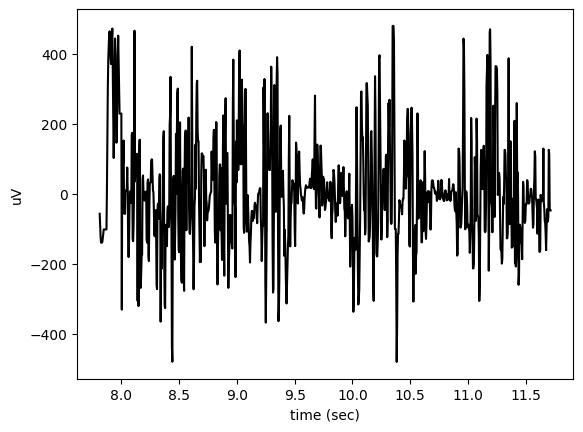

In [2]:
import pynapple as nap
import matplotlib.pyplot as plt
import numpy as np

# load data and plot some stuff
data = nap.load_file(nwbpath)

print("Here is the organized data by Pynapple")
print(data)
print("")

print("Here is sample data, loaded lazily.")
print(data['ElectricalSeries'])
print("")

print("Here is how you index out your data (or one way at least!)")
data_snippet = data['ElectricalSeries']['EEG1A-B'][2000:3000]
plt.plot(data_snippet, color='k')
plt.xlabel('time (sec)')
plt.ylabel('uV')

## Indexing data using time series

Time (s)        EEG1A-B    EEG2A-B    EEG3A-B
------------  ---------  ---------  ---------
360.5          16.8479     6.16416   6.63377
360.50390625   -1.3497    -3.93258   5.40103
360.5078125    -5.40013  -13.7358   -3.99128
360.51171875   -1.4671   -16.6122   -9.09835
360.515625     -1.11489  -14.5576   -6.69157
...
362.984375     21.7789     2.52463  -0.645272
362.98828125   23.8921     3.22906  -1.5258
362.9921875    21.1919     3.05295  -1.23229
362.99609375   15.263      2.99425   3.93348
363.0          13.5606     4.22699   5.57714
dtype: float64, shape: (641, 3)


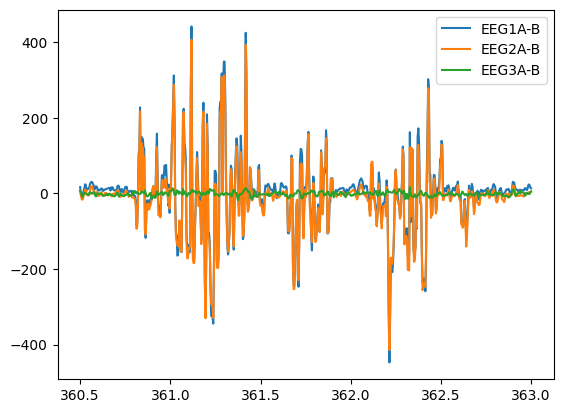

In [3]:
# index out times from 360-380
idxStart = [360.5] # sec
idxEnd = [363] # sec 363

# make an interval set to restrict data
if 'epochs' in locals():
    del epochs
epochs = nap.IntervalSet(start=idxStart, end=idxEnd, time_units="s")

# restrict data
data_int = data['ElectricalSeries'].restrict(epochs)
print(data_int)

# define lead names
lead_names = data_int.columns.to_list()

# plot results
plt.plot(data_int)
plt.legend(lead_names)


## Multitaper method to calculate power

In [ ]:
from decode_lab_code.EEG.multitaper_spectrogram_python import multitaper_spectrogram

# define data
data = np.array(data_int[lead_names[0]])

# Define parameter space
fs = 256  # Sampling Frequency
frequency_range = [0, 25]  # Limit frequencies from 0 to 25 Hz
time_bandwidth = 3  # Set time-half bandwidth
num_tapers = 5  # Set number of tapers (optimal is time_bandwidth*2 - 1)
window_params = [1, 0.5]  # Window size, step size (sec)

# nitty gritty
min_nfft = 0  # No minimum nfft
detrend_opt = 'constant'  # detrend each window by subtracting the average
multiprocess = True  # use multiprocessing
cpus = 9  # use 3 cores in multiprocessing
weighting = 'unity'  # weight each taper at 1
plot_on = True  # plot spectrogram
return_fig = False  # do not return plotted spectrogram
clim_scale = False  # do not auto-scale colormap
verbose = True  # print extra info
xyflip = False  # do not transpose spect output matrix

# Compute the multitaper spectrogram
spect, stimes, sfreqs = multitaper_spectrogram(data, fs, frequency_range, time_bandwidth, num_tapers, window_params, min_nfft, detrend_opt, multiprocess, cpus,
                                               weighting, plot_on, return_fig, clim_scale, verbose, xyflip)



## Welchs method for coherence

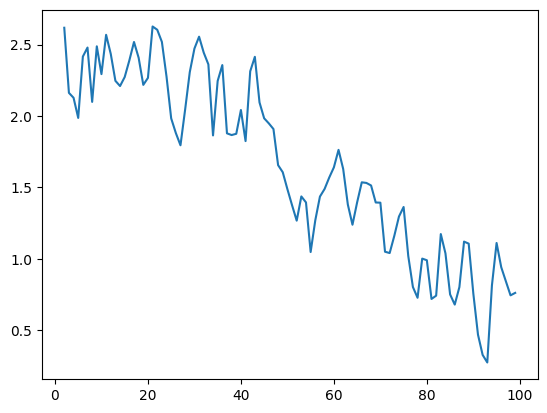

In [5]:
from decode_lab_code.EEG.spectral import power
power, f, logpower = power(data = np.array(data_int[lead_names[0]]), fs = 256.0)
plt.plot(f, logpower)

Text(0.5, 0, 'Frequency (hz)')

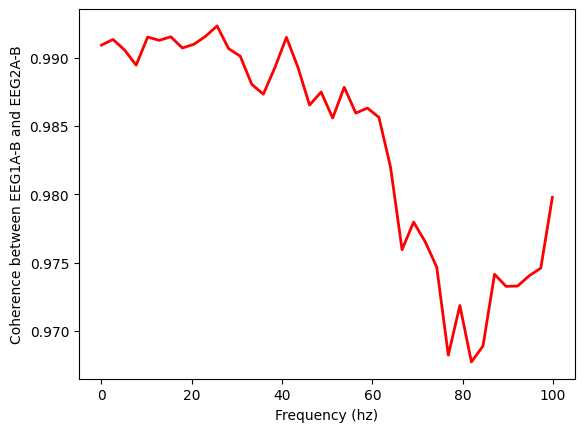

In [8]:
from scipy.signal import coherence
import numpy as np

# extract out some data
x_name = lead_names[0]
y_name = lead_names[1]
x = data['ElectricalSeries'][x_name][10000:20000]
y = data['ElectricalSeries'][y_name][10000:20000]

# Coherence analysis
fs = 256
f, cxy = coherence(x,y,fs,nperseg=100)
idx = np.logical_and(f>-1,f<100)
plt.plot(f[idx],cxy[idx],linewidth=2,color='r')
plt.ylabel(('').join(['Coherence between ', x_name, ' and ', y_name]))
plt.xlabel('Frequency (hz)')